In [1]:
# Propagation from initial Keplerian orbit
# Perturbation:
# N/A
# Maneuver: 
# No

# Obserbation:
# AZ/EL
# TOD / IERS_2010
# Output:
# pvs_kep_NoPert.cvs
# export_all_NoPert.csv
# export_visible_NoPert.csv

In [2]:
%matplotlib inline

from math import radians, pi
import pandas as pd
import numpy as np
import plotly.express as px


import orekit
vm = orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime
setup_orekit_curdir()


from org.orekit.orbits import KeplerianOrbit, PositionAngle
from org.orekit.propagation.analytical import KeplerianPropagator
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.utils import Constants
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.attitudes import LofOffset
from org.orekit.bodies import CelestialBodyFactory, OneAxisEllipsoid
from org.orekit.forces.drag import IsotropicDrag
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.maneuvers import ImpulseManeuver
from org.orekit.frames import FramesFactory, LOFType
from org.orekit.models.earth.atmosphere import HarrisPriester
from org.orekit.orbits import CircularOrbit, OrbitType, PositionAngle
from org.orekit.propagation import PropagationType, SpacecraftState
from org.orekit.propagation.events import DateDetector, EventEnablingPredicateFilter, PythonEnablingPredicate,\
     PositionAngleDetector, PythonEventDetector, AbstractDetector, EventDetector
from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder, DSSTPropagatorBuilder
from org.orekit.propagation.semianalytical.dsst.forces import DSSTAtmosphericDrag, DSSTNewtonianAttraction, DSSTZonal
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.utils import Constants, IERSConventions, PVCoordinatesProvider
from orekit.pyhelpers import absolutedate_to_datetime

from org.orekit.propagation.numerical import NumericalPropagator
#from org.orekit.propagation.conversion import DormandPrince853Integrator

#from .inputs import Inputs
#from .utils import JULIAN_DAYS_PER_YEAR, KILOMETERS, normalize_around_0_radians, normalize_around_pi, seconds_in_day

In [3]:
utc = TimeScalesFactory.getUTC()

# Given by ADS
a = 7000.0 * 1000  
e = 0.2
i = radians(68.0) #98.0)     
omega = radians(280) #0.2)   # perigee argument
raan = radians(0) #90.0)  # right ascension of ascending node
lv = radians(0.1)    # True anomaly

mass = 625.0

epochDate = AbsoluteDate(2020, 1, 1, 0, 0, 00.000, utc)
initialDate = epochDate

## Inertial frame where the satellite is defined
#inertialFrame = FramesFactory.getEME2000()
inertialFrame = FramesFactory.getTOD(IERSConventions.IERS_2010, False)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         inertialFrame)

## Orbit construction as Keplerian
initialOrbit = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngle.TRUE,
                              inertialFrame, epochDate, Constants.WGS84_EARTH_MU)
initialOrbit

<KeplerianOrbit: Keplerian parameters: {a: 7000000.0; e: 0.2; i: 68.0; pa: 280.0; raan: 0.0; v: 0.1;}>

In [4]:
propagator = KeplerianPropagator(initialOrbit)

In [5]:
propagator.getInitialState()

<SpacecraftState: SpacecraftState{orbit=Keplerian parameters: {a: 7000000.0; e: 0.2; i: 68.0; pa: 280.0; raan: 0.0; v: 0.1;}, attitude=org.orekit.attitudes.Attitude@7dda48d9, mass=1000.0, additional={}}>

In [6]:
propagator.setSlaveMode();
duration = 2*24*3600
finalDate = initialDate.shiftedBy(float(duration))
stepT = 60 #seconds

extrapDate = initialDate
pvs = []
states = []

for cpt in range(int(duration/stepT)):
    extrapDate = extrapDate.shiftedBy(float(stepT))
    currentState = propagator.propagate(extrapDate)
    states.append(currentState)
    pvs.append(propagator.getPVCoordinates(extrapDate, inertialFrame))
    

print(currentState)
print(pvs[-1])
print(len(states))
print(len(pvs))
KepElt = pd.DataFrame(data=states, columns=['kep'])
#KepElt.insert(1,'pv',pvs,True)
#KepElt['a'] = KepElt['pv'].apply(lambda x: x.getA())
#KepElt['e'] = KepElt['pv'].apply(lambda x: x.getE())
#KepElt['i'] = KepElt['pv'].apply(lambda x: x.getI())
#KepElt['kep'] = KepElt['pv'].apply(lambda x: x.getOrbit())
#KepElt['raan'] = KepElt['pv'].apply(lambda x: x.getRightAscensionOfAscendingNode())
#KepElt['lv'] = KepElt['pv'].apply(lambda x: x.getTrueAnomaly())
print(KepElt.iloc[1])
KepElt.head()
KepElt['datetime'] = KepElt['kep'].apply(lambda x: absolutedate_to_datetime(x.getDate()))

SpacecraftState{orbit=Keplerian parameters: {a: 7000000.0; e: 0.2; i: 68.0; pa: 280.0; raan: 0.0; v: 10657.374474004362;}, attitude=org.orekit.attitudes.Attitude@9f674ac, mass=1000.0, additional={}}
{2020-01-03T00:00:00.000, P(-5878924.20887427, 2026915.249938587, 5016791.288112003), V(-3698.6620803831215, -2022.6394025697214, -5006.208194502109), A(4.594236625874319, -1.583985087740091, -3.920500666672958)}
2880
2880
kep    SpacecraftState{orbit=Keplerian parameters: {a...
Name: 1, dtype: object


In [7]:
KepElt.to_csv('pvs_kep_NoPert.csv')

In [8]:
#KepElt

In [9]:
# Generate Station measurements

# Input data: given by ADS
# Longitude : 21.038 deg
# Latitude : 67.8790708 deg
# Altitude : 0.527 km

# Ground station creation
longitude = radians(21.038)
latitude  = radians(67.8790708)
altitude  = 527.0
station1 = GeodeticPoint(latitude, longitude, altitude)
sta1Frame = TopocentricFrame(earth, station1, "Kiruna")

prop_data = []

prop_data = pd.DataFrame(data=pvs, columns=['pv'])
prop_data['Position'] = prop_data['pv'].apply(lambda x: x.getPosition())
prop_data['datetime'] = prop_data['pv'].apply(lambda x: absolutedate_to_datetime(x.getDate()))
prop_data['elevation'] = prop_data['pv'].apply(lambda x: sta1Frame.getElevation(x.getPosition(), inertialFrame, x.getDate())*180.0/pi )
prop_data['azimuth'] = prop_data['pv'].apply(lambda x: sta1Frame.getAzimuth(x.getPosition(), inertialFrame, x.getDate())*180.0/pi )
prop_data.set_index('datetime', inplace=True, drop=False)
prop_data.index.name = 'Timestamp'
prop_data['groundpoint'] = prop_data['pv'].apply(lambda pv: earth.transform(pv.position, inertialFrame, pv.date))
prop_data['latitude'] = np.degrees(prop_data.groundpoint.apply(lambda gp: gp.latitude))
prop_data['longitude'] = np.degrees(prop_data.groundpoint.apply(lambda gp: gp.longitude))
prop_data['day'] = prop_data.datetime.dt.dayofyear
prop_data['hour'] = prop_data.datetime.dt.hour

#print(prop_data)
print('Measurement length: ',len(prop_data))
prop_data.head()

#print(prop_data.iloc[:])


Measurement length:  2880


,pv,Position,datetime,elevation,azimuth,groundpoint,latitude,longitude,day,hour
Timestamp,,,,,,,,,,
2020-01-01 00:01:00,"{2020-01-01T00:01:00.000, P(1523257.855447767,...","{1,523,257.855447767; -2,020,540.570705898; -5...",2020-01-01 00:01:00,-71.946174,224.065416,"{lat: -63.3371752938 deg, lon: -52.987860082 d...",-63.337175,-52.987860,1,0
2020-01-01 00:02:00,"{2020-01-01T00:02:00.000, P(2052063.7571996625...","{2,052,063.7571996625; -1,959,342.229777856; -...",2020-01-01 00:02:00,-69.450607,221.166327,"{lat: -59.8595552782 deg, lon: -43.6758741489 ...",-59.859555,-43.675874,1,0
2020-01-01 00:03:00,"{2020-01-01T00:03:00.000, P(2564292.11778199, ...","{2,564,292.11778199; -1,882,307.9481292653; -4...",2020-01-01 00:03:00,-66.922155,218.794707,"{lat: -55.8773743308 deg, lon: -36.2803756777 ...",-55.877374,-36.280376,1,0
2020-01-01 00:04:00,"{2020-01-01T00:04:00.000, P(3056054.580827869,...","{3,056,054.580827869; -1,790,242.082047342; -4...",2020-01-01 00:04:00,-64.371426,216.795685,"{lat: -51.5741966849 deg, lon: -30.3618460429 ...",-51.574197,-30.361846,1,0
2020-01-01 00:05:00,"{2020-01-01T00:05:00.000, P(3523827.623792144,...","{3,523,827.623792144; -1,684,113.8303816074; -...",2020-01-01 00:05:00,-61.805550,215.066501,"{lat: -47.0778297279 deg, lon: -25.5441495027 ...",-47.077830,-25.544150,1,0


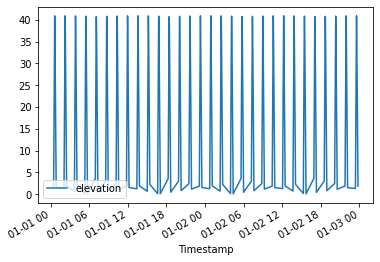

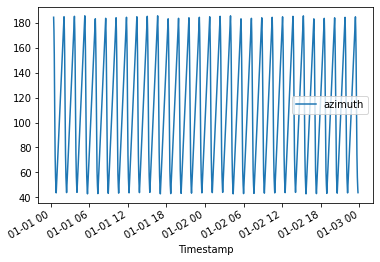

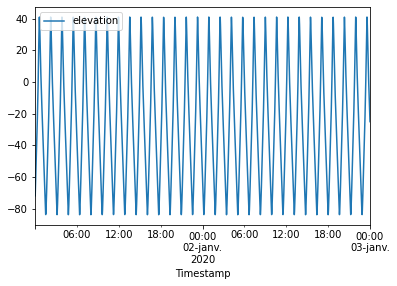

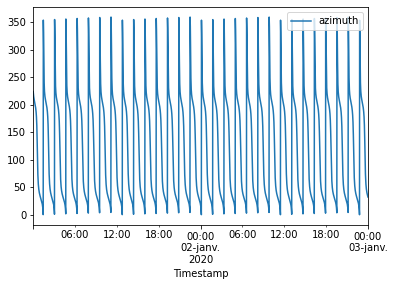

In [10]:
prop_data[prop_data.elevation>0][:].plot(y='elevation');
prop_data[prop_data.elevation>0][:].plot(y='azimuth');

prop_data[:][:].plot(y='elevation');
prop_data[:][:].plot(y='azimuth');

prop_data.to_csv('export_all_NoPert.csv')
prop_data[prop_data.elevation>0][:].to_csv('export_visible_NoPert.csv')
